# WeatherPy

In [1]:
# Dependencies
import requests
import json
import time
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns 
from   citipy import citipy

# Generate and or retrieve API key from http://openweathermap.org/appid
# Store Open Weather Map developer API key in config.py then get variable
from config import wkey

## Generate Cities List

In [2]:
# Find the cities nearest to the equator
latitude   = 0
cities     = []
countries  = []
columns    = ['City', 'Country', 'Max Temperature', 'Humidity', 'Wind Speed', 'Cloudiness', 'Longitude', 'Latitude']

for longitude in range(-180,180): # Range is longitude left to right
    city = citipy.nearest_city(latitude, longitude)
    cities.append(city.city_name)
    countries.append(city.country_code)

equatorial_cities = {'City':    cities,
                     'Country': countries}

# Create dataframe, drop duplicates, and reset index
equatorial_cities_df = pd.DataFrame(equatorial_cities, columns=columns).drop_duplicates().reset_index(drop=True)
# Drop NaN after populating weather data
equatorial_cities_df.head()

,City,Country,Max Temperature,Humidity,Wind Speed,Cloudiness,Longitude,Latitude
0,vaitupu,wf,NaN,NaN,NaN,NaN,NaN,NaN
1,saleaula,ws,NaN,NaN,NaN,NaN,NaN,NaN
2,samalaeulu,ws,NaN,NaN,NaN,NaN,NaN,NaN
3,lufilufi,ws,NaN,NaN,NaN,NaN,NaN,NaN
4,samusu,ws,NaN,NaN,NaN,NaN,NaN,NaN


## Perform API Calls

In [3]:
# Find weather data of cities nearest to the equator
base_url                = "https://api.openweathermap.org/data/2.5/weather"
params                  = { "q": '', "APPID": wkey} 
weather_metrics         = '-' * 80
use_backup_weather_data = False

print("Beginning Data Retrieval")
print(weather_metrics)
# Use iterrows to iterate through pandas dataframe
for index, row in equatorial_cities_df.iterrows():

    # Get city and country code from dataframe
    city_and_country = f"{row['City']},{row['Country']}"

    # Add keyword to params dict
    params['q']      = city_and_country
    
    try:
        # Assemble url and make API request
        # response = requests.get(base_url, params=params).json()
        # results  = response.get('cod')
        # city     = response.get('name')
        
        results = 400
        # Parse and print weather data and add to dataframe 
        if results == 200:
            sys     = response['sys']
            country = sys['country']
            # weather_metrics = f"Weather data available for equatorial city: {city}, {country}\n"
            weather_metrics += f"\n{city}, {country}: "
            
            main    = response['main']
            temp    = 9/5 (float(main['temp_max']) - 273) + 32 # Convert Kelvin to Fahrenheit
            humid   = main['humidity']
            equatorial_cities_df.set_value(index, "Max Temperature", temp)
            equatorial_cities_df.set_value(index, "Humidity",        humid)
            weather_metrics += f"max temp: {temp} humidity: {humid} "
            
            wind    = response['wind']
            speed   = wind['speed']
            equatorial_cities_df.set_value(index, "Wind Speed", speed)
            weather_metrics += f"wind: {speed} "
            
            clouds  = response['clouds']
            clouds  = clouds['all']
            equatorial_cities_df.set_value(index, "Cloudiness", clouds)
            weather_metrics += f"clouds: {clouds} "
            
            coord   = response['coord']
            lon     = coord['lon']
            lat     = coord['lat']
            equatorial_cities_df.set_value(index, "Longitude", lon)
            equatorial_cities_df.set_value(index, "Latitude",  lat)
            weather_metrics += f"lon: {lon} lat: {lat} "
            
            print(weather_metrics)
            print('-' * 80)
            
        else:
            # print(response)
            use_backup_weather_data = True
            print('''\n WARNING: If you do not get a respond from server do not try to repeat your request immediately, 
          but only after 10 min. Also, we recommend to store your previous requested data.''')
            
            print('''\n          If account exceeds the limits, then a notification about limits exceeding 
          is sent. If it repeats again, then the account is blocked for an hour. Therefore, 
          the lock period is increased by one hour until 4 hour block sets. When blocking 
          repeats the fifth time, then the lock period lasts 24 hours. This rule is cycled. 
          Please be carefull with the number of API calls you complete''')
            print('-' * 80)
            break
            
    except:
        continue
        
print("Data Retrieval Complete")

Beginning Data Retrieval
--------------------------------------------------------------------------------

          but only after 10 min. Also, we recommend to store your previous requested data.

          If account exceeds the limits, then a notification about limits exceeding 
          is sent. If it repeats again, then the account is blocked for an hour. Therefore, 
          the lock period is increased by one hour until 4 hour block sets. When blocking 
          repeats the fifth time, then the lock period lasts 24 hours. This rule is cycled. 
          Please be carefull with the number of API calls you complete
--------------------------------------------------------------------------------
Data Retrieval Complete


## Scatter Plot of Weather Data

In [4]:
# Drop NaN from dataframe and reset index
equatorial_cities_df = equatorial_cities_df.dropna(axis=0, how='any').reset_index(drop=True)

# Initial weather data collected on April, 01, 2018
# equatorial_cities_df.to_csv('equator_weather_data.csv', index=False)

# Set date for scatter plot title
date = time.strftime("%m/%d/%Y")

# API call to Open Weather Map fails use previously stored weather data
if use_backup_weather_data:
    equatorial_cities_df = pd.read_csv('equator_weather_data.csv')
    date                 = '04/01/2018'
    
print(f"There are {equatorial_cities_df.shape[0]} equatorial cities with weather data available in dataframe.")
equatorial_cities_df.head()

There are 5 equatorial cities with weather data available in dataframe.


,City,Country,Max Temperature,Humidity,Wind Speed,Cloudiness,Longitude,Latitude
0,vaitupu,wf,82.4,79,9.32057,88,-178.8300,-7.4800
1,saleaula,ws,78.8,79,7.45645,88,-172.3367,-13.4483
2,samalaeulu,ws,78.8,79,7.45645,88,-172.3106,-13.4974
3,lufilufi,ws,78.8,87,5.59234,87,-171.6015,-13.8765
4,samusu,ws,77.0,80,6.21371,88,-171.4300,-14.0057


In [5]:
def create_scatter(data, **kwargs):
    try:
        sns.set() # sets seaborn grid
        sns.lmplot(x=kwargs['xdata'], y=kwargs['ydata'], data=data, fit_reg=False, legend_out=False)

        plt.title(kwargs['title'])
        plt.xlabel(kwargs['xlabel'])
        plt.ylabel(kwargs['ylabel'])

        plt.show()
    
    except:
        print(f"ERROR: Insufficient weather data given to create scatter plot: '{title}'")
        pass

### Latitude vs Temperature Plot

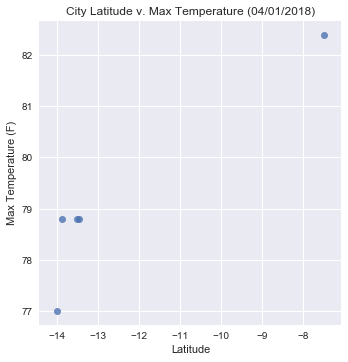

In [6]:
title  = f'City Latitude v. Max Temperature ({date})'
xlabel = 'Latitude'
ylabel = 'Max Temperature (F)'
xdata  = 'Latitude'
ydata  = 'Max Temperature'

create_scatter(data=equatorial_cities_df, title=title, xlabel=xlabel, ylabel=ylabel, xdata=xdata, ydata=ydata)

### Latitude vs. Humidity Plot

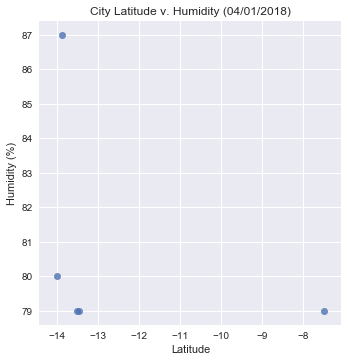

In [7]:
title  = f'City Latitude v. Humidity ({date})'
xlabel = 'Latitude'
ylabel = 'Humidity (%)'
xdata  = 'Latitude'
ydata  = 'Humidity'

create_scatter(data=equatorial_cities_df, title=title, xlabel=xlabel, ylabel=ylabel, xdata=xdata, ydata=ydata)

### Latitude vs. Cloudiness Plot

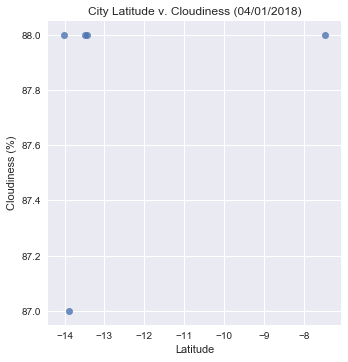

In [8]:
title  = f'City Latitude v. Cloudiness ({date})'
xlabel = 'Latitude'
ylabel = 'Cloudiness (%)'
xdata  = 'Latitude'
ydata  = 'Cloudiness'

create_scatter(data=equatorial_cities_df, title=title, xlabel=xlabel, ylabel=ylabel, xdata=xdata, ydata=ydata)

### Latitude vs. Wind Speed Plot

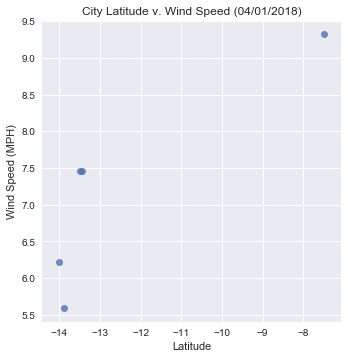

In [9]:
title  = f'City Latitude v. Wind Speed ({date})'
xlabel = 'Latitude'
ylabel = 'Wind Speed (MPH)'
xdata  = 'Latitude'
ydata  = 'Wind Speed'

create_scatter(data=equatorial_cities_df, title=title, xlabel=xlabel, ylabel=ylabel, xdata=xdata, ydata=ydata)